In [315]:
import numpy as np
from scipy import special as spec

**Abstract**: Here we attempt to code [Ruedenberg's overlap equation](https://aip.scitation.org/doi/abs/10.1063/1.1669874) (eqs. 3, 23, 24, 25, 26, 27, 28, 29, A7). For debugging purposes, we will compare our results with those of [Roothans' overlap expressions](https://pubs.aip.org/aip/jcp/article-abstract/19/12/1445/201949/A-Study-of-Two-Center-Integrals-Useful-in).

# Parameters

In [316]:
def parameters(zeta_A, zeta_B, R):
    """Parameters (see Eq. 3)"""
    rho_A = R * zeta_A
    rho_B = R * zeta_B
    return (rho_A, rho_B)

# Overlap Expression

In [349]:
def B(n_A, n_B, l_A, l_B, m, mu, v):
    """Eq.29 from Ruedenberg's paper"""
    
    # Definitions (Part 1)
    array1 = np.array([mu + v + l_A + l_B, mu + n_A + n_B])
    Delta = np.min(array1) + 1
    array2 = np.array([0, mu - n_B - l_A, v - n_B - l_A + m])
    beta_1 = np.max(array2)
    beta_2 = np.min(np.array([n_A - l_A, v]))
    
    beta = beta_1
    value = 0
    while beta <= beta_2:
        array1 = np.array([0, mu - beta - l_A - l_B, v - beta - l_A - l_B + m])
        beta1_prime = np.max(array1)
        beta2_prime = np.min(np.array([n_B - l_B, v - beta]))
        beta_prime = beta1_prime
        while beta_prime <= beta2_prime:
            array1 = np.array([m, v - beta - beta_prime - l_B + m])
            alpha1 = np.max(array1)
            alpha = alpha1
            while alpha <= l_A:
                array1 = np.array([m, v - beta - beta_prime - alpha + m])
                alpha1_prime = np.max(array1)
                alpha_prime = alpha1_prime
                while alpha_prime <= l_B:
                    lamb = 0
                    while lamb <= mu:
                        factor = spec.comb(n_A - l_A, beta)
                        factor *= spec.comb(n_B - l_B, beta2_prime)
                        factor *= spec.factorial(Delta, exact = True) / spec.factorial(mu + beta + beta_prime + l_A + l_B + 1, exact = True)
                        factor *= spec.comb(l_A, alpha, exact = True) * spec.comb(l_A, alpha - m, exact = True) * (-1)**alpha
                        factor *= spec.comb(l_B, alpha_prime, exact = True) * spec.comb(l_B, alpha_prime - m, exact = True) * (-1)**(alpha_prime)
                        factor *= spec.comb(alpha + alpha_prime - m, v - beta - beta_prime, exact = True)
                        factor *= spec.factorial(alpha - alpha_prime + beta + l_B, exact = True) * spec.factorial(alpha_prime - alpha + beta_prime + l_A, exact = True)
                        factor *= spec.comb(alpha - alpha_prime + beta + l_B + lamb, lamb, exact = True) * (-1)**(lamb) 
                        factor *= spec.comb(alpha_prime - alpha + beta_prime + l_A + mu - lamb, mu - lamb, exact = True)
                        factor *= spec.comb(mu, lamb, exact = True)
                        value += factor
                        lamb += 1
                    alpha_prime += 1
                alpha += 1
            beta_prime += 1
        beta += 1
    return value

def A(n_A, n_B, l_A, l_B, m, mu, v):
    """Eq.28 from Ruedenberg's paper"""
    
    numerator = (2*l_A + 1) * (2*l_B + 1) * spec.comb(l_A + m, m, exact = True) * spec.comb(l_B + m, m, exact = True) 
    denominator = spec.comb(l_A, m, exact = True) * spec.comb(l_B, m, exact = True) * spec.comb(2 * n_A, n_A, exact = True) * spec.comb(2 * n_B, n_B, exact = True) 
    factor1 = np.sqrt(numerator / denominator)
    
    array = np.array([mu + v + l_A + l_B, mu + n_A + n_B])
    Delta = np.min(array) + 1
    numerator = spec.factorial(n_A + n_B - v) * B(n_A, n_B, l_A, l_B, m, mu, v)
    denominator = spec.factorial(n_A, exact = True) * spec.factorial(n_B, exact = True) * spec.comb(2 * mu, mu, exact = True) * spec.factorial(Delta, exact = True)
    factor2 = numerator / denominator 
    value = factor1 * factor2 * (-1)**(l_A + l_B)
    return value

def g(l_A, l_B, n_A, n_B, m, rho_A, rho_B, mu):
    """Eq.25 from Ruedenberg's paper"""
    arrays = np.array([0, np.abs(l_A - l_B) - mu, mu - (l_A + l_B)])
    v_1 = np.max(arrays)
    v_2 = n_A + n_B - m
    v = v_1
    g_mu = 0
    while v <= v_2:
        g_mu += A(n_A, n_B, l_A, l_B, m, mu, v) * (rho_A + rho_B)**v
        v += 1
    return g_mu

def f(rho_A, rho_B, mu):
    """Eq.B2 from Ruedenberg's paper"""
    b = mu + 3/2
    z = 1/8 * (rho_A - rho_B)**2
    factor = np.exp(-1/2 * (rho_A + rho_B))
    factor *= (2 * mu + 1) / (2**(2 * mu + 1))
    factor *= np.sqrt(np.pi) * spec.gamma(2 * b - 2) / (spec.gamma(b) * spec.gamma(b - 1/2))
    factor *= spec.hyp0f1(b, z)
#    factor = np.exp(-1/2 * (rho_A + rho_B)) * spec.hyp0f1(b, 2 * z)
    f_mu = factor
    return f_mu

def overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, R):
    """Eq.23 from Ruedenberg's paper"""
    rho_A, rho_B = parameters(zeta_A, zeta_B, R)
    if zeta_A == zeta_B:
        v = np.abs(l_A - l_B)
        series = 0
        while v <= n_A + n_B - m:
            series += A(n_A, n_B, l_A, l_B, m, 0, v) * (2 * rho_A)**v
            v += 1
        overlap = series * np.exp(-rho_A) 
    else:
        sum_rhos = rho_A + rho_B
        diff_rhos = rho_A - rho_B
        factor_1 = (2 * rho_A / sum_rhos)**(n_A + 1/2)
        factor_2 = (2 * rho_B / sum_rhos)**(n_B + 1/2)
        mu = 0
        series = 0
        while mu <= n_A + n_B:
            series += f(rho_A, rho_B, mu) * g(l_A, l_B, n_A, n_B, m, rho_A, rho_B, mu) * (rho_A - rho_B)**mu 
            mu += 1
        overlap = factor_1 * factor_2 * series
    return overlap

# Compare to Roothan Expressions ($\zeta_A = \zeta_B$). Will use C$_2$ as an example

In [350]:
import matplotlib.pyplot as plt
def check_plot(value1, value2, r):
    # Plot the values
    plt.plot(r, value1, label = 'Ruedenberg')
    plt.plot(r, value2, label = 'Roothan')
    plt.legend()
    plt.show();
    
    # Check if values agree
    if np.all(value1 == value2) == False:
        RMSE = np.sqrt(np.sum((value1-value2)**2)/value.shape[0])
        if RMSE < 1:
            print(f'Does not fit but the deviation is extremely low. RMSE = {RMSE}')
        else:
            print(f'Does not fit and the deviation is high. RMSE = {RMSE}')
    else:
        print('Fits perfectly!')    
    return None

## Overlap between 1s and 1s

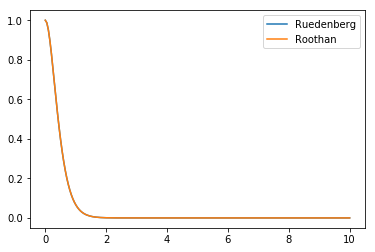

Fits perfectly!


In [351]:
## Ruedenberg
n_A = 1
n_B = 1
l_A = 0
l_B = 0
m = 0 
zeta_A = 5.52 # 1s
zeta_B = 5.52 # 1s
r = np.linspace(0,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_1s1s(r,zeta):
    rho = zeta * r
    overlap = (1 + rho + 1/3 * rho**2) * np.exp(-rho)
    return overlap

value2 = overlap_1s1s(r,zeta_A)
check_plot(value1, value2, r)

## Overlap between 2s and 2s

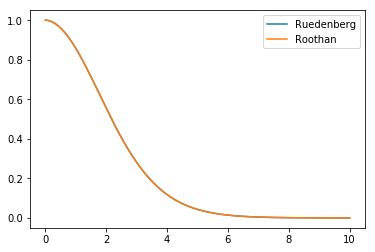

Does not fit but the deviation is extremely low. RMSE = 1.8637371805127777e-17


In [352]:
## Ruedenberg
n_A = 2
n_B = 2
l_A = 0
l_B = 0
m = 0 
zeta_A = 1.72 # 2s
zeta_B = 1.72 # 2s
r = np.linspace(0,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_2s2s(r,zeta):
    rho = zeta * r
    overlap = (1 + rho + 4/9 * rho**2 + 1/9 * rho**3 + 1/45 * rho**4) * np.exp(-rho)
    return overlap

value2 = overlap_2s2s(r,zeta_A)
check_plot(value1, value2, r)

## Overlap between 2s and 2p

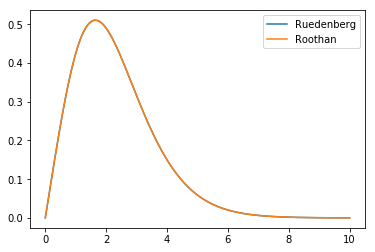

Does not fit but the deviation is extremely low. RMSE = 4.8816848118372365e-17


In [353]:
## Ruedenberg
n_A = 2
n_B = 2
l_A = 0
l_B = 1
m = 0 
zeta_A = 1.72 # 2s
zeta_B = 1.72 # 2p
r = np.linspace(0,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_2s2p(r,zeta):
    rho = zeta * r
    overlap = 1/(2 * np.sqrt(3)) * rho * (1 + rho + 7/15 * rho**2 + 2/15 * rho**3) * np.exp(-rho)
    return overlap

value2 = overlap_2s2p(r,zeta_A)
check_plot(value1, value2, r)

## Overlap between 2p and 2p in $\sigma$-fashion

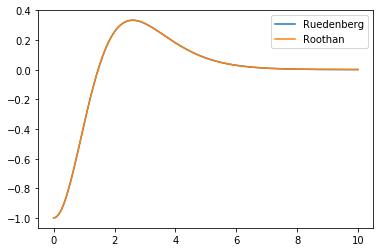

Fits perfectly!


In [354]:
## Ruedenberg
n_A = 2
n_B = 2
l_A = 1
l_B = 1
m = 0 
zeta_A = 1.72 # 2s
zeta_B = 1.72 # 2p
r = np.linspace(0,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_2p2psigma(r, zeta):
    rho = zeta * r
    overlap = (-1 - rho - 1/5 * rho**2 + 2/15 * rho**3 + 1/15 * rho**4) * np.exp(-rho)
    return overlap

value2 = overlap_2p2psigma(r,zeta_A)
check_plot(value1, value2, r)

## Overlap between 2p and 2p in $\pi$-fashion

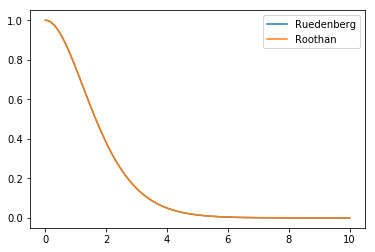

Fits perfectly!


In [355]:
## Ruedenberg
n_A = 2
n_B = 2
l_A = 1
l_B = 1
m = 1 
zeta_A = 1.72 # 2s
zeta_B = 1.72 # 2p
r = np.linspace(0,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_2p2ppi(r, zeta):
    rho = zeta * r
    overlap = (1 + rho + 2/5 * rho**2 + 1/15 * rho**3) * np.exp(-rho)
    return overlap

value2 = overlap_2p2ppi(r,zeta_A)
check_plot(value1, value2, r)

# Compare to Roothan Expressions ($\zeta_A \neq \zeta_B$). Will use CO as an example

## Overlap between 1s and 1s

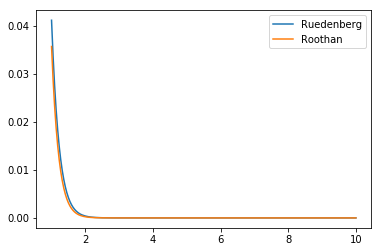

Does not fit but the deviation is extremely low. RMSE = 0.0007921344871517156


In [356]:
## Ruedenberg
n_A = 1
n_B = 1
l_A = 0
l_B = 0
m = 0 
zeta_A = 5.52 # 2s C
zeta_B = 7.43 # 2p O
r = np.linspace(1,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_1s1s_gen(r, zeta_A, zeta_B):
    zeta = (zeta_A + zeta_B) / 2
    tau = (zeta_A - zeta_B) / (zeta_A + zeta_B)
    rho = (zeta_A + zeta_B) * r / 2 
    kappa = 1/2 * (tau + 1/tau)
    rho_a = zeta_A * r
    rho_b = zeta_B * r
    
    u1 = 1 - kappa
    u2 = 1 + kappa
    term3 = -u1 * (2 * u2 + rho_a) * np.exp(-rho_a)
    term4 = u2 * (2 * u1 + rho_b) * np.exp(-rho_b)
    overlap = np.sqrt(1 - tau**2) / (tau * rho) * (term3 + term4)
    return overlap

value2 = overlap_1s1s_gen(r, zeta_A, zeta_B)
check_plot(value1, value2, r)

## Overlap between 1s and 2s

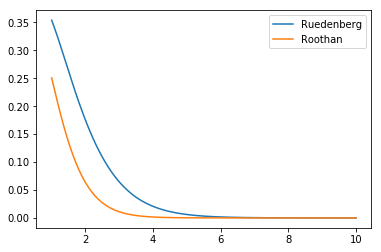

Does not fit but the deviation is extremely low. RMSE = 0.05069241495738617


In [357]:
## Ruedenberg
n_A = 1
n_B = 2
l_A = 0
l_B = 0
m = 0 
zeta_A = 5.52 # 2s C
zeta_B = 2.25 # 2p O
r = np.linspace(1,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_1s2s_gen(r, zeta_A, zeta_B):
    zeta = (zeta_A + zeta_B) / 2
    tau = (zeta_A - zeta_B) / (zeta_A + zeta_B)
    rho = (zeta_A + zeta_B) * r / 2 
    kappa = 1/2 * (tau + 1/tau)
    rho_a = zeta_A * r
    rho_b = zeta_B * r
    
    u1 = 1 - kappa
    u2 = 1 + kappa
    u3 = 2 - 3 * kappa
    u4 = 1 - 2 * kappa 
    term3 = -u1 * (2 * u2 * u3 + u4 * rho_a) * np.exp(-rho_a)
    term4 = u2 * (2 * u1 * u3 + 4 * u1 * rho_b + rho_b**2) * np.exp(-rho_b)
    overlap = (np.sqrt(1 - tau**2) / (np.sqrt(3) * tau * rho)) * (term3 + term4)
    return overlap

value2 = overlap_1s2s_gen(r, zeta_A, zeta_B)
check_plot(value1, value2, r)

## Overlap between 2s and 2s

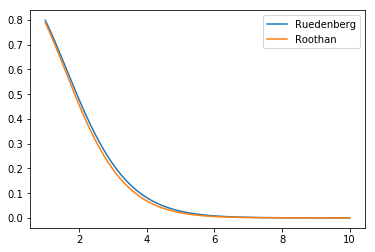

Does not fit but the deviation is extremely low. RMSE = 0.011452838351935632


In [358]:
## Ruedenberg
n_A = 2
n_B = 2
l_A = 0
l_B = 0
m = 0 
zeta_A = 1.72 # 2s C
zeta_B = 2.25 # 2s O
r = np.linspace(1,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_2s2s_gen(r, zeta_A, zeta_B):
    zeta = (zeta_A + zeta_B) / 2
    tau = (zeta_A - zeta_B) / (zeta_A + zeta_B)
    rho = (zeta_A + zeta_B) * r / 2 
    kappa = 1/2 * (tau + 1/tau)
    rho_a = zeta_A * r
    rho_b = zeta_B * r
    
    u1 = 1 - kappa
    u2 = 1 + kappa
    u3 = 7 - 12 * kappa**2
    u4 = 2 - 3 * kappa 
    u5 = 1 - 2 * kappa
    u6 = 2 + 3 * kappa
    u7 = 1 + 2 * kappa
    term3 = -u1 * (2 * u2 * u3 + 4 * u2 * u4 * rho_a + u5 * rho_a**2) * np.exp(-rho_a)
    term4 = u2 * (2 * u1 * u3 + 4 * u1 * u6 * rho_b + u7 * rho_b**2) * np.exp(-rho_b)
    overlap = np.sqrt(1 - tau**2) / (3 * tau * rho) * (term3 + term4)
    return overlap

value2 = overlap_2s2s_gen(r, zeta_A, zeta_B)
check_plot(value1, value2, r)

## Overlap between 1s and 2p

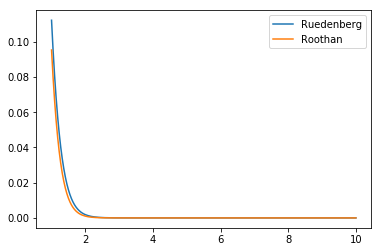

Does not fit but the deviation is extremely low. RMSE = 0.002735110733400415


In [359]:
## Ruedenberg
n_A = 1
n_B = 2
l_A = 0
l_B = 1
m = 0 
zeta_A = 5.52 # 1s C
zeta_B = 7.43 # 2p O
r = np.linspace(1,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_1s2p_gen(r, zeta_A, zeta_B):
    zeta = (zeta_A + zeta_B) / 2
    tau = (zeta_A - zeta_B) / (zeta_A + zeta_B)
    rho = (zeta_A + zeta_B) * r / 2 
    kappa = 1/2 * (tau + 1/tau)
    rho_a = zeta_A * r
    rho_b = zeta_B * r
    
    u1 = 1 - kappa
    u2 = 1 + kappa
    term3 = (-u1**2) * (6 * u2 * (1 + rho_a) + 2 * rho_a**2) * np.exp(-rho_a)
    term4 = u2 * (6 * (u1**2) * (1 + rho_b) + 4 * u1 * rho_b**2 + rho_b**3) * np.exp(-rho_b)
    overlap = np.sqrt((1 + tau)/(1 - tau)) * (1 / (tau * rho**2)) * (term3 + term4)
    return overlap

value2 = overlap_1s2p_gen(r, zeta_A, zeta_B)
check_plot(value1, value2, r)

## Overlap between 2s and 2p

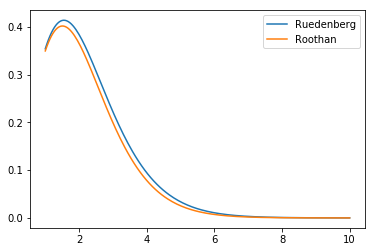

Does not fit but the deviation is extremely low. RMSE = 0.011659354954621013


In [360]:
## Ruedenberg
n_A = 2
n_B = 2
l_A = 0
l_B = 1
m = 0 
zeta_A = 1.72 # 2s C
zeta_B = 2.25 # 2p O
r = np.linspace(1,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_2s2p_gen(r, zeta_A, zeta_B):
    zeta = (zeta_A + zeta_B) / 2
    tau = (zeta_A - zeta_B) / (zeta_A + zeta_B)
    rho = (zeta_A + zeta_B) * r / 2 
    kappa = 1/2 * (tau + 1/tau)
    rho_a = zeta_A * r
    rho_b = zeta_B * r
    
    u1 = 1 - kappa
    u2 = 1 + kappa
    u3 = 3 + 4 * kappa
    u4 = 5 + 6 * kappa
    u5 = 2 + 3 * kappa
    u6 = 1 + 2 * kappa
    term3 = (-u1**2) * (6 * u2 * u3 * (1 + rho_a) + 2 * u4 * rho_a**2 + 2 * rho_a**3) * np.exp(-rho_a)
    term4 = u2 * (6 * (u1**2) * u3 * (1 + rho_b) + 4 * u1 * u5 * rho_b**2 + u6 * rho_b**3) * np.exp(-rho_b)
    overlap = np.sqrt((1 + tau)/(1 - tau)) * (1 / (np.sqrt(3) * tau * rho**2)) * (term3 + term4)
    return overlap

value2 = overlap_2s2p_gen(r, zeta_A, zeta_B)
check_plot(value1, value2, r)

## Overlap between 2p and 2p in $\sigma$-fashion

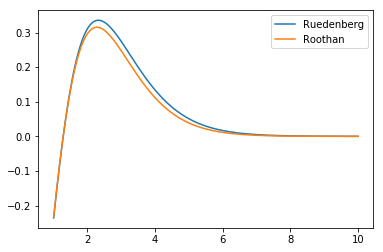

Does not fit but the deviation is extremely low. RMSE = 0.01334063241577473


In [361]:
## Ruedenberg
n_A = 2
n_B = 2
l_A = 1
l_B = 1
m = 0 
zeta_A = 1.72 # 2p C
zeta_B = 2.25 # 2p O
r = np.linspace(1,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_2p2psigma_gen(r, zeta_A, zeta_B):
    zeta = (zeta_A + zeta_B) / 2
    tau = (zeta_A - zeta_B) / (zeta_A + zeta_B)
    rho = (zeta_A + zeta_B) * r / 2 
    kappa = 1/2 * (tau + 1/tau)
    rho_a = zeta_A * r
    rho_b = zeta_B * r
    
    u1 = 1 - kappa
    u2 = 1 + kappa
    u3 = 5 + 6 * kappa
    u4 = 5 - 6 * kappa
    term1 = -u1**2 * (48 * u2**2 * (1 + rho_a + 1/2 * rho_a**2) + 2 * u3 * rho_a**3 + 2 * rho_a**4) * np.exp(-rho_a)
    term2 = u2**2 * (48 * u1**2 * (1 + rho_b + 1/2 * rho_b**2) + 2 * u4 * rho_b**3 + 2 * rho_b**4) * np.exp(-rho_b)
    overlap = (1/(np.sqrt(1 - tau**2) * tau * rho**3)) * (term1 + term2)
    return overlap

value2 = overlap_2p2psigma_gen(r, zeta_A, zeta_B)
check_plot(value1, value2, r)

## Overlap between 2p and 2p in $\pi$-fashion

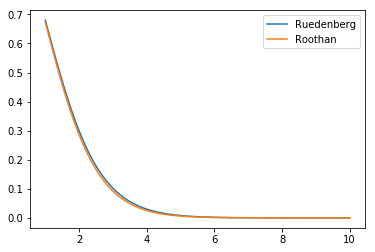

Does not fit but the deviation is extremely low. RMSE = 0.006269326521887414


In [362]:
## Ruedenberg
n_A = 2
n_B = 2
l_A = 1
l_B = 1
m = 1 
zeta_A = 1.72 # 2p C
zeta_B = 2.25 # 2p O
r = np.linspace(1,10, 200)
value1 = overlap(n_A, n_B, l_A, l_B, m, zeta_A, zeta_B, r)

## Roothan
def overlap_2p2ppi_gen(r, zeta_A, zeta_B):
    zeta = (zeta_A + zeta_B) / 2
    tau = (zeta_A - zeta_B) / (zeta_A + zeta_B)
    rho = (zeta_A + zeta_B) * r / 2 
    kappa = 1/2 * (tau + 1/tau)
    rho_a = zeta_A * r
    rho_b = zeta_B * r
    
    u1 = 1 - kappa
    u2 = 1 + kappa
    term3 = -u1**2 * (24 * (1 + rho_a) * u2**2 + 12 * u2 * rho_a**2 + 2 * rho_a**3) * np.exp(-rho_a)
    term4 = u2**2 * (24 * (1 + rho_b) * u1**2 + 12 * u1 * rho_b**2 + 2 * rho_b**3) * np.exp(-rho_b)
    overlap = (1/(np.sqrt(1 - tau**2) * tau * rho**3)) * (term3 + term4)
    return overlap

value2 = overlap_2p2ppi_gen(r, zeta_A, zeta_B)
check_plot(value1, value2, r)